In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt

${\boldsymbol x}_k \in {\mathbb R}^{M\times 1}$  ${\boldsymbol x}_{k,m} \in \{ 0,1\}$


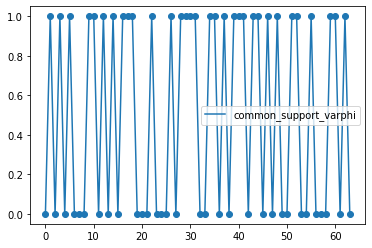

In [2]:
## generate channel support
K=4
# 6 is a nice value
np.random.seed(2)
def common_channel_support(p01 = 0.1, p10=0.3, M= 64):
    p0 = p10/(p10+p01)
    p1 = 1-p0

    # generate Markov chain
    tmp_support = np.array([0.0 for m in range(M)])
    if np.random.uniform(0,1,1)[0] < p0:
        tmp_support[0] = 0
    for i in range(M - 1):
        if tmp_support[i] == 0:
            if np.random.uniform(0,1,2)[0] < p01:
                tmp_support[i+1] = 1
            else:
                tmp_support[i+1] = 0
        else:
            if np.random.uniform(0,1,2)[1] < p10:
                tmp_support[i+1] = 0
            else:
                tmp_support[i+1] = 1
    return tmp_support
p01 = 0.5
p10 = 0.5
M = 64
common_support_varphi = common_channel_support(p01, p10, M)
plt.scatter(range(M), common_support_varphi)
plt.plot(range(M), common_support_varphi)
plt.legend(['common_support_varphi'])


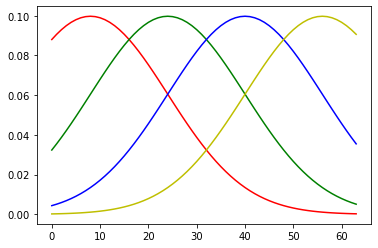

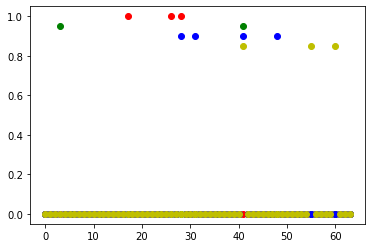

In [3]:
np.random.seed(3)
color_list = ['r', 'g', 'b', 'y']
sigma = 4
less_likely_to_appear = 5


# generate individual AoAs support
def pdf_for_all_user(user_index, K = 4, M = 64, sigma = 6):
    x = np.linspace(0,M-1,M)
    mu = int(user_index*(M/K)+0.5*M/K)
    return 1/(np.power(2*np.pi*np.power(sigma,2), 0.5)) * np.exp(-0.5 * np.power((x-mu)/np.power(sigma,2),2))

conditinal_pdf_list = [pdf_for_all_user(k,K,M,sigma=sigma) for k in range(K)]
for k in range(K):
    plt.plot(range(M), conditinal_pdf_list[k], color_list[k])

# initialization for all users' channel support
channel_support_for_all_users = np.array([[0 for m in range(M)] for k in range(K)] )

for k in range(K):
    for m in range(M):
        if common_support_varphi[m] == 1:
            maxi = np.max(conditinal_pdf_list[k])*less_likely_to_appear
            if np.random.uniform(0,maxi,K*M)[m+k*m] < conditinal_pdf_list[k][m]:
                channel_support_for_all_users[k][m] = 1
            else:
                channel_support_for_all_users[k][m] = 0

plt.figure(2)
for k in range(K):
    plt.scatter(np.array(range(M)), channel_support_for_all_users[k] * (1-0.05*k), color=color_list[k])
    # plt.plot(np.array(range(M)), channel_support_for_all_users[k] * (k+1)/K, color=color_list[k])



$\varphi_{k,j} = \frac{d}{\lambda}\operatorname{cos}(\varphi_{\theta}) \in [-0.5, 0.5)$

$$
\mathbf{a}_{X}(x)=\left[1, e^{-\mathrm{i} 2 \pi x}, \ldots, e^{-\mathrm{i} 2 \pi(X-1) x}\right]^{\mathrm{T}}
$$

$\Delta \varphi_{k,j}=\varphi_{k,j} -\varphi_{k,j}^g \in [0,\frac{1}{M})$

$$
\psi_l^g = 
\begin{cases}
\frac{n_l-1}{N}\quad &,\frac{n_l-1}{N} < 0.5 \\
\frac{n_l-1}{N}-1 &, \frac{n_l-1}{N}\geq 0.5
\end{cases}
$$

$\mathbf{a}_{M,k}^{D F T}(\boldsymbol{\varphi})=\mathbf{D}_{M}(\Delta \boldsymbol{\varphi}) \boldsymbol{x}_k = \sum_{j}^{J_k} \beta_{k,j} {\mathbf a}_M(\varphi_{k,j})$

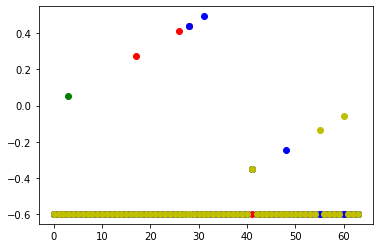

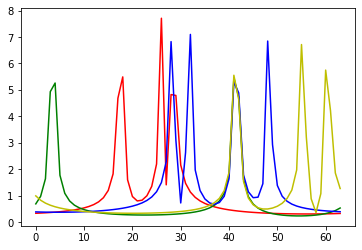

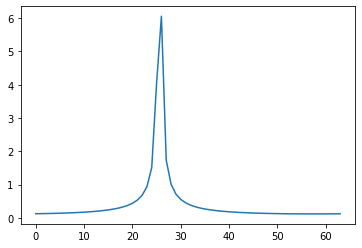

In [4]:
def array_response(M, x):
    m = np.linspace(0, M-1, M)
    return np.exp(1j*2*np.pi*m*x)


def DFT_matrix(M):
    return np.power(M,-0.5)*np.mat(np.fft.fft(np.eye(M)))


np.random.seed(3)
Delta_varphi_min = 0
Delta_varphi_max = 1/M
Delta_varphi = np.random.uniform(Delta_varphi_min, Delta_varphi_max, M)
Varphi_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])

Varphi_true = [[] for k in range(K)]
for k in range(K):
    for m in range(M):
        if channel_support_for_all_users[k][m] == 1:
            Varphi_true[k].append(Delta_varphi[m] + Varphi_grid[m])
        else:
            Varphi_true[k].append(-0.6)

[plt.scatter(range(M), Varphi_true[k], color = color_list[k]) for k in range(K)]

Beta_true = np.random.normal(0, 1, M)

a_M_k = np.array([[np.complex128(0) for m in range(M)] for k in range(K)])
for k in range(K):
    sum_tmp = np.array([np.complex128(0) for m in range(M)])
    for m, varphi in enumerate(Varphi_true[k]):
        if varphi != -0.6:
            sum_tmp = sum_tmp + array_response(M, varphi)
    a_M_k[k] = sum_tmp

DFT_M = DFT_matrix(M)
a_M_k_DFT = [DFT_M * np.mat(np.reshape(a_M_k[k], (M,-1))) for k in range(K)]

plt.figure(3)
[plt.plot(range(M), np.abs(a_M_k_DFT[k]), color_list[k]) for k in range(K)]
# plt.plot(range(M), np.abs(a_M_k_DFT[1]), color_list[1])
plt.figure(5)
plt.plot(range(M), np.abs(DFT_M * np.reshape(np.mat(array_response(M, 0.4)), (M,-1))))

${\mathbf D}_M(\Delta {\boldsymbol \varphi})= [D_M(\Delta \varphi_1),\dots,D_M(\Delta \varphi_M)] \in {\mathbb C}^{M\times M}$

$$
D_M(\Delta {\varphi_1},m^{\prime})=\begin{cases}
\begin{aligned}
f_M({2\pi}(\frac{m^{\prime}-m} {M} - 1+\Delta\varphi))\ &, \frac{m^{\prime}-1}{M} < 0.5 \\
f_M({2\pi}(\frac{m^{\prime}-m} {M}+\Delta\varphi)) &, \frac{m^{\prime}-1}{M} \geq 0.5
\end{aligned}

\end{cases}
$$
$$
f_M(x) = \frac{1}{\sqrt{M}}e^{jx(M-1)/2} \frac{\operatorname{sin}(Mx/2)}{\operatorname{sin}(x/2)}
$$


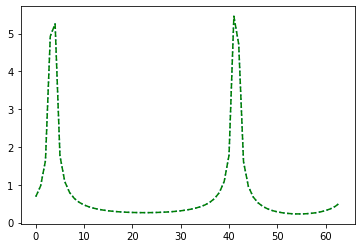

In [5]:
## generate D_M
def f_N(N, x):
    if abs(x) == 0:
        return N
    else:
        return 1/np.sqrt(N)*cmath.exp(1j*x*(N-1)/2)*(cmath.sin((N)*x/2))/(cmath.sin(x/2))

def generate_DM(M, Delta_varphi):
    DM = np.matrix([np.complex128(0) for m in range(M * M)]).reshape((M,M))
    for col in range(M):
        if col/float(M) < 0.5:
            DM[:,col] = np.array([(f_N(M, 2*np.pi *(m/M - col/M - Delta_varphi[col]) )) for m in range(M)]).reshape(M,1)
        else:
            DM[:,col] = np.array([(f_N(M, 2*np.pi *(m/M - col/M + 1 - Delta_varphi[col]) )) for m in range(M)]).reshape(M,1)
    return DM

DM_varphi = generate_DM(M, Delta_varphi)

DM_mul_x = DM_varphi * np.reshape(np.mat(channel_support_for_all_users[1]), (M,1))
plt.plot(range(M), np.abs(DM_mul_x), linestyle='dotted')
plt.plot(range(M), np.abs(a_M_k_DFT[1]), color_list[1],linestyle='dashed')




${\mathbf \Phi}^H \in {\mathbb C}^{\tau \times M}$

${\mathbf V}({\omega_l}) = \operatorname{Diag}({\mathbf{a}_M({\omega_l})}) {\mathbf U}_M^H$

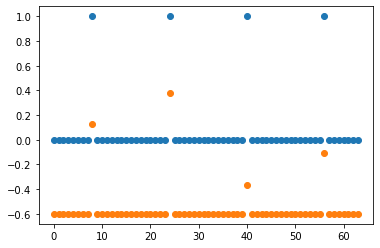

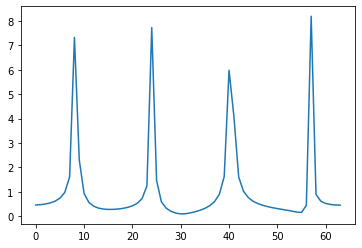

In [24]:
np.random.seed(4)

Omega_support = np.array([1 if (m+M/8) % int(M/4) == 0 else 0 for m in range(M)])
plt.scatter(range(M), Omega_support)

Delta_omega_min = 0
Delta_omega_max = 1/M
Delta_omega = np.random.uniform(Delta_varphi_min, Delta_varphi_max, M)
Omega_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])

Omega_true = []
for m in range(M):
    if Omega_support[m] == 1:
        Omega_true.append(Delta_omega[m] + Omega_grid[m])
    else:
        Omega_true.append(-0.6)

plt.scatter(range(M),Omega_true)

a_M = np.array([np.complex128(0) for m in range(M)])
for m in range(M):
    if Omega_support[m] == 1:
        a_M = a_M + array_response(M, Omega_true[m])
a_M_DFT = DFT_matrix(M) * np.reshape(np.mat(a_M), (M,1))

plt.figure(6)
plt.plot(range(M), np.abs(a_M_DFT))

# generate V(omega_l)
def generate_V_wl(M,omega):
    return np.diag(array_response(M,omega))*DFT_matrix(M).H

def generate_Phi_H(M, tau, mode = 'fixed'):
    if mode == 'fixed':
        return np.mat([[np.complex128(1) for m in range(M)] for t in range(tau)])
    elif mode == 'random':
        x = np.random.randint(0,2,(tau, M))
        return np.mat(np.exp(1j*np.pi*x))


$${\boldsymbol p}_{l,k} = {\mathbf \Phi}^H {\mathbf V}({\omega_l}){\mathbf D}_M({\Delta}{\boldsymbol \varphi}_k) {\boldsymbol x}_k
+ {\mathbf N}_l ,\forall l \in \{1,\dots,L\}$$

In [ ]:
# generate 2D object list P_lk
def generate_P_lk(M,K):
    
    return 0